# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [7]:
!pip install patool
import patoolib
patoolib.extract_archive('/content/drive/My Drive/Data Science/images_racoon.rar')
import tensorflow as tf
import csv
import numpy as np
from PIL import Image

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

     |████████████████████████████████| 81kB 2.5MB/s 
patool: Extracting /content/drive/My Drive/Data Science/images_racoon.rar ...
patool: running /usr/bin/unrar x -- "/content/drive/My Drive/Data Science/images_racoon.rar"
patool:     with cwd='./Unpack_a6bt3l33'
patool: ... /content/drive/My Drive/Data Science/images_racoon.rar extracted to `images'.


In [0]:
import pandas as pd

### Change directory

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/Data Science')

### Load the training data from train.csv file

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3 

EPOCHS = 10 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 32 # Depends on your GPU or CPU RAM.

DATASET_FOLDER = "/content/drive/My Drive/Data Science/"
TRAIN_CSV = DATASET_FOLDER+"train_labels.csv"
#VALIDATION_CSV = DATASET_FOLDER+"validation.csv"

#images_zip_path = DATASET_FOLDER + "images.zip"

#from zipfile import ZipFile

### Print the shape of the train dataset

In [30]:
batch_images.shape

(173, 128, 128, 3)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [0]:
IMAGE_SIZE = 128 # MobileNet takes images of size 128*128*3

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [0]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(csvfile)
    for col, row in enumerate(reader):
        #print('row is',row)       
        #for i, r in enumerate(row[1:7]): # Parse row with seven entities
        #    row[i+1] = int(r)
              
        #path, image_height, image_width, x0, y0, x1, y1, _, _ = row 
        #print(row[0],row[2],row[1],row[4],row[5],row[6],row[7]) 
        path, image_height, image_width, x0, y0, x1, y1 = row[0],int(row[2]) ,int(row[1]),int(row[4]),int(row[5]),int(row[6]),int(row[7])  
        #path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
        path = DATASET_FOLDER + 'images/' + path
        coords[col, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / image_height
        paths.append(path)



In [46]:
reader.line_num

173

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [0]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    #print('Iteration is :',i,f)
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))

### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [0]:
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
# In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

### Define a custom loss function IoU which calculates Intersection Over Union

In [0]:
gt=coords
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_func(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [51]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

#checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", verbose=1, save_best_only=True,
#                              save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
#stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
#reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit(batch_images,gt,epochs=30,batch_size = 32,verbose=1)

Epoch 1/30
173/173 [==============================] - 6s 37ms/step - loss: 151.7732 - IoU: 0.7089
Epoch 2/30
173/173 [==============================] - 5s 30ms/step - loss: 98.8333 - IoU: 0.7705
Epoch 3/30
173/173 [==============================] - 5s 30ms/step - loss: 82.1949 - IoU: 0.7822
Epoch 4/30
173/173 [==============================] - 5s 30ms/step - loss: 88.0675 - IoU: 0.7893
Epoch 5/30
173/173 [==============================] - 5s 30ms/step - loss: 73.7772 - IoU: 0.8048
Epoch 6/30
173/173 [==============================] - 5s 30ms/step - loss: 65.6275 - IoU: 0.8211
Epoch 7/30
173/173 [==============================] - 5s 30ms/step - loss: 59.1742 - IoU: 0.8366
Epoch 8/30
173/173 [==============================] - 5s 30ms/step - loss: 62.6993 - IoU: 0.8338
Epoch 9/30
173/173 [==============================] - 5s 30ms/step - loss: 65.5333 - IoU: 0.8356
Epoch 10/30
173/173 [==============================] - 5s 30ms/step - loss: 59.6020 - IoU: 0.8443
Epoch 11/30
173/173 [=======

### Pick a test image from the given data

In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image
import cv2
filename = './images/raccoon-16.jpg'
unscaled = cv2.imread(filename) # Original image for display

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

### Predict the coordinates of the bounding box for the given test image

In [64]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox
region

array([ 25.578983,  25.0077  ,  86.36996 , 109.52928 ], dtype=float32)

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

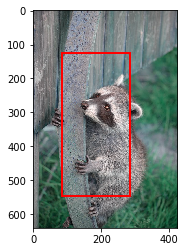

In [65]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()

# Time Series Prediction using LSTM

### Download Data
Link: https://datamarket.com/data/set/2324/daily-minimum-temperatures-in-melbourne-australia-1981-1990#!ds=2324&display=line

#### Description
Daily minimum temperatures in Melbourne, Australia, 1981-1990

Units: Degrees Celcius

#### Steps before loading
- Rename the column name with temprature values to "Temprature"
- In the last, there is one extra row in the data, remove it by opening the file and save it again.
- There are some values in Temprature column which have a "?" before them, they will give error, remove "?" before them and save the file
- If you don't want to do these steps, just load the data file given by Great Learning.

#### Mount google drive

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Change your present working directory

In [0]:
import os
os.chdir('/content/drive/My Drive/Data Science')

### Load your data file

In [0]:
import pandas as pd
import matplotlib.pyplot as plt


In [70]:
df = pd.read_csv('/content/drive/My Drive/Data Science/daily-minimum-temperatures-in-me.csv')
df.head(5)

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


#### Plot data

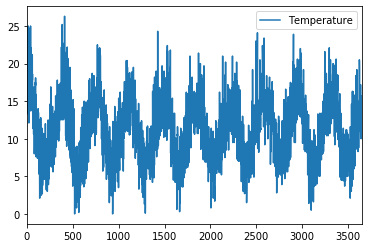

In [72]:
df.plot()

#### Descibe your dataframe

In [73]:
df.describe()

,Temperature
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


#### Check for null values

In [80]:
df.isnull().sum()

Date           0
Temperature    0
dtype: int64

#### Drop null values

In [75]:
df.dropna()

,Date,Temperature
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


#### Get the representation of the distribution of data in the form of histogram

> Indented block



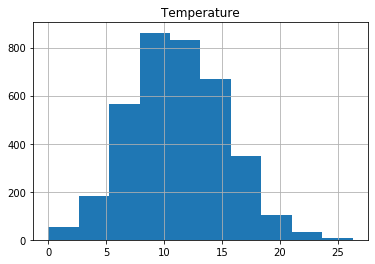

In [76]:
hist = df.hist()

#### Check the maximum and minimum values

In [81]:
print(df['Temperature'].min() , df['Temperature'].max())

0.0 26.3


### Normalize the data

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
df.drop('Date',axis=1,inplace=True)
#Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

#### Check the maximum and minimum values of scaled data

In [96]:
print(scaled.max(),scaled.min())


1.0 0.0


#### Look into some of the scaled values

In [99]:
scaled

array([[0.78707224],
       [0.68060837],
       [0.7148289 ],
       ...,
       [0.51330798],
       [0.59695817],
       [0.49429658]])

### Split data into Training and Testing

In [0]:
#70% examples will used for training (in the begining)
train_size = int(len(scaled) * 0.70)

#30% will be used for Test
test_size = len(scaled - train_size)

#### Print train and test size

In [102]:
#Split the data
train, test = scaled[0:train_size, :], scaled[train_size: len(scaled), :]
print('train: {}\ntest: {}'.format(len(train), len(test)))

train: 2555
test: 1095


## Create the sequential data
Map the temprature at a particular time t to the temprature at time t+n, where n is any number you define.

For example: to map tempratures of consecutive days, use t+1, i.e. loop_back = 1

#### Define your function to create dataset

In [0]:
#window - how long the sequence will be
def create_dataset(dataset, window=1):
    
    dataX, dataY = [], []
    
    for i in range(len(dataset)-window):
        
        a = dataset[i:(i+window), 0]        
        dataX.append(a)
        dataY.append(dataset[i + window, 0])
    
    return np.array(dataX), np.array(dataY)

#### Use function to get training and test set

In [0]:
#Create Input and Output
window_size = 1
X_train, y_train = create_dataset(train, window_size)
X_test, y_test = create_dataset(test, window_size)

#### Transform the prepared train and test input data into the expected structure using numpy.reshape()

In [105]:
#Make it 3 Dimensional Data - needed for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_train.shape)
print(X_test.shape)

(2554, 1, 1)
(1094, 1, 1)


## Define Model

### Define sequntial model, add LSTM layer and compile the model

In [0]:
import tensorflow as tf

In [107]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(32, input_shape=(window_size, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


### Summarize your model

In [0]:
model.summary()

### Train the model

In [109]:
model.fit(X_train, y_train, epochs=200, validation_data=(X_test, y_test), batch_size=32)

Train on 2554 samples, validate on 1094 samples
Epoch 1/200
2554/2554 [==============================] - 0s 126us/sample - loss: 0.0100 - val_loss: 0.0088
Epoch 2/200
2554/2554 [==============================] - 0s 112us/sample - loss: 0.0100 - val_loss: 0.0087
Epoch 3/200
2554/2554 [==============================] - 0s 107us/sample - loss: 0.0100 - val_loss: 0.0087
Epoch 4/200
2554/2554 [==============================] - 0s 108us/sample - loss: 0.0100 - val_loss: 0.0087
Epoch 5/200
2554/2554 [==============================] - 0s 108us/sample - loss: 0.0100 - val_loss: 0.0087
Epoch 6/200
2554/2554 [==============================] - 0s 109us/sample - loss: 0.0100 - val_loss: 0.0088
Epoch 7/200
2554/2554 [==============================] - 0s 108us/sample - loss: 0.0100 - val_loss: 0.0087
Epoch 8/200
2554/2554 [==============================] - 0s 112us/sample - loss: 0.0100 - val_loss: 0.0089
Epoch 9/200
2554/2554 [==============================] - 0s 117us/sample - loss: 0.0099 - val_lo

## Make Predictions and Evaluate your model

In [0]:
#Un-normalize the predited data
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
trainPredict = scaler.inverse_transform(trainPredict)
testPredict = scaler.inverse_transform(testPredict)

## Plot the results

In [0]:
import matplotlib.pyplot as plt

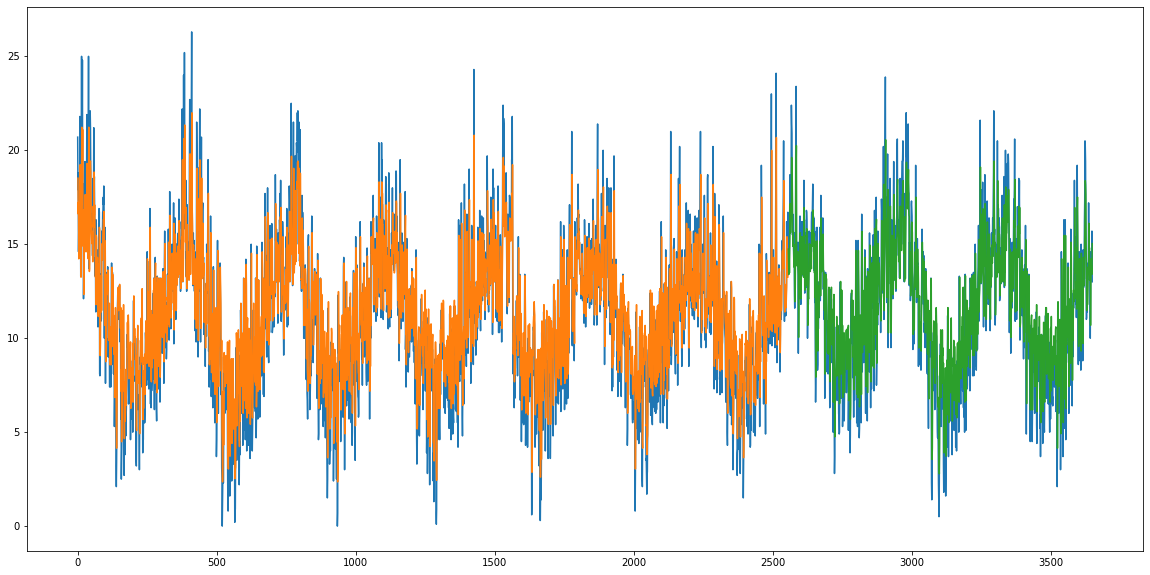

In [112]:
trainPredictPlot = np.empty_like(scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[window_size:len(trainPredict)+window_size, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(window_size*2):len(scaled), :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(scaled))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()